In [35]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import * 

from numpy import *

# Binary System of Sirius and The Third Star
---
## Question: 
### How would a third star affect the existing binary star system of Sirius A and B?
---

Binary-star systems are pretty common and stable in the universe, as one of the nearest and most common one, Sirius system is something realistic we can discuss. The small fluctuation on orbit of Sirius A led the assumption that a third tiny star is orbiting around it. We can model the orbit of this potential third star and then expand the trinary-star system by discussing different position of the third star in this system.

And mostly it was stated that the trinary system (especially when there is one in the system significantly lighter than others) is very unstable, they will eventually collapse or be thrown away until there are only 2 left in the system. We will test that in the model and see how initial position can affect the orbits.

# Method:

The model uses ode solver to calculate celestial problems. We use the derivate of position and velocity, which are velocity and accelaration, tp update the orbit. Different initial velocities are tested to make sure the stars would not collapse at the very beginning. 

In [36]:
# Units 
s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter



<Unit('meter')>

In [37]:
"""
Some constant:

r_0: distance between Sirius A and B.
T: period of this system, about 50 years.
m_sun: mass of the sun.
r_sun: radius of the sun.
"""
r_0 = 2.992e12 * m
T = 51 * 365 * 24 * 60*60 * s
m_sun = 1.989e30*kg
r_sun = 6.955*10e8 *m

<Quantity(6955000000.0, 'meter')>

Given the period of 50 years and the radius, we can calculate the velocity from the expected circumstance divided by time.

In [38]:
init = State(xA = -r_0 *1/3,
             yA = 0 *m,
             vxA = 0 *m/s,
             vyA = 2*pi*r_0/(3*T),
             xB = r_0*2/3,
             yB = 0 * m,
             vxB = 0 *m/s,
             vyB = -4*pi*r_0 /(3*T)
            )

,values
xA,-997333333333.3334 meter
yA,0 meter
vxA,0.0 meter / second
vyA,3896.219537683942 meter / second
xB,1994666666666.6667 meter
yB,0 meter
vxB,0.0 meter / second
vyB,-7792.439075367884 meter / second


The mass of Sirius A is 2.1 times the mass of the sun, rounded to 2.
The mass of Sirius B is 0.98 times the mass of the sun, rounded to 1.
Therefore the center of mass is at 1/3 of the distance from Sirius A to B.

In [39]:

system = System(init = init,
                 G = 6.674e-11 * N / kg**2 * m**2,
                 mA = 2*m_sun, 
                 mB = m_sun,
                 rA = 1.71 * r_sun,
                 rB= 0.008*r_sun,
                 t_0 = 0 *s,
                 t_end = T)


,values
init,xA -997333333333.3334 meter yA ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
mA,3.978e+30 kilogram
mB,1.989e+30 kilogram
rA,11893050000.0 meter
rB,55640000.0 meter
t_0,0 second
t_end,1608336000 second


In [40]:
def universal_gravity(state, system):    
    """"
    Calculating gravitational force between Sirius A and Sirius B
    Taking the center of mass as origin
    xA, yA: posistion of Sirius A 
    xB, yB: position of Sirius B
    vxA, vyA: velocity of Sirius A
    vxB, vyB: velocity of Sirius B
    
    AB: the vector from B to A
    BA: the vector from A to B
    """
    xA, yA, vxA, vyA, xB, yB, vxB, vyB = state
    unpack(system)
    posA = Vector (xA, yA)
    posB = Vector (xB, yB)
    
    AB = posB-posA
    BA = posA-posB
    forceA =AB.hat() * G * mA *mB/ AB.mag**2
    forceB = BA.hat() * G *mA*mB / BA.mag **2
    
    return forceA, forceB
    

In [41]:
def slope_func(state, t, system):
    xA, yA, vxA, vyA, xB, yB, vxB, vyB= state
    unpack(system)
    
    forceA,forceB = universal_gravity(state, system)
    accA = forceA / mA
    accB = forceB / mB
    accAx = accA[0]
    accAy = accA[1]
    accBx = accB[0]
    accBy = accB[1]
    
    
    return vxA, vyA, accAx ,accAy, vxB, vyB, accBx, accBy
    

In [42]:
results, details = run_ode_solver(system, slope_func)
details

,values
sol,None
t_events,[]
nfev,140
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


In [43]:
t_final = get_last_label(results) * s

<Quantity(1608336000.0, 'second')>

In [44]:
t_final.to(UNITS.years)

<Quantity(50.96618096735545, 'year')>

In [45]:
ts = linspace(t_0, t_final, 500)
results, details = run_ode_solver(system, slope_func, t_eval=ts)

In [46]:
# Converting from meter to kilometer
xa = results.xA/10e3;
ya = results.yA/10e3;
xb = results.xB/10e3;
yb = results.yB/10e3;

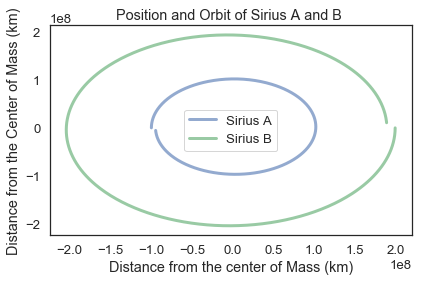

In [47]:
plot (xa, ya, 'b',label = 'Sirius A')
plot (xb,yb, 'g', label = 'Sirius B')

decorate(title = "Position and Orbit of Sirius A and B ",
        xlabel = 'Distance from the center of Mass (km)',
        ylabel = 'Distance from the Center of Mass (km)')

## Adding the third star:

Scientists believe there is a third star orbiting around Sirius A with a small mass and period less than 5 years. The distance is belived to be smaller than 3 arcsenconds from Sirius A, which is approximately 20 times the radius if Sirius A.

In [48]:
"""
TC: Period of the third star.
Adding position and velocity of Star C into the state object.
"""

TC = 4.2* 365 * 24 * 60 *60 *s
init = State (   xA = -r_0 *1/3,
                 yA = 0 *m,
                 vxA = 0 *m/s,
                 vyA = 2*pi*r_0/(3*T),
                 xB = r_0*2/3,
                 yB = 0 * m,
                 vxB = 0 *m/s,
                 vyB = -4*pi*r_0 /(3*T),
                 xC = -r_0/3 + 40*system.rA,
                 yC = 0*m,
                 vxC = 0 *m / s,
                 vyC = -80 * pi * system.rA  / TC
    )

,values
xA,-997333333333.3334 meter
yA,0 meter
vxA,0.0 meter / second
vyA,3896.219537683942 meter / second
xB,1994666666666.6667 meter
yB,0 meter
vxB,0.0 meter / second
vyB,-7792.439075367884 meter / second
xC,-521611333333.3334 meter
yC,0 meter


In [49]:

system = System(mC = 0.05*m_sun,
                 init = init,
                 G = 6.674e-11 * N / kg**2 * m**2,
                 mA = 2*m_sun, 
                 mB = m_sun,
                 rA = 1.71 * r_sun,
                 rB= 0.008*r_sun,
                 t_0 = 0 *s,
                 t_end = T
                 
                )

,values
mC,9.945e+28 kilogram
init,xA -997333333333.3334 meter yA ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
mA,3.978e+30 kilogram
mB,1.989e+30 kilogram
rA,11893050000.0 meter
rB,55640000.0 meter
t_0,0 second
t_end,1608336000 second


Since the third star is significantly lighter than the 2

In [50]:
def universal_gravity(state, system):    
    """"
    Calculating gravitational force between Sirius A and Sirius B
    Taking the center of mass as origin
    xA, yA: posistion of Sirius A 
    xB, yB: position of Sirius B
    vxA, vyA: velocity of Sirius A
    vxB, vyB: velocity of Sirius B
    xC, yC: position of the third star
    vxC, vyC: velocity of the third star
    """
    xA, yA, vxA, vyA, xB, yB, vxB, vyB, xC, yC, vxC, vyC= state
    unpack(system)
    posA = Vector (xA, yA)
    posB = Vector (xB, yB)
    posC = Vector (xC, yC)
    AB = posB-posA
    BA = posA-posB
    AC = posA - posC
    BC = posB - posC
    
    forceAC = AC.hat() * G * mA * mC / AC.mag **2
    forceBC = BC.hat() * G * mB * mC / BC.mag **2
    forceA =AB.hat() * G * mA *mB/ AB.mag**2 
    forceB = BA.hat() * G *mA*mB / BA.mag **2 
    
    forceC = forceAC + forceBC
    
    return forceA, forceB,forceC
    

In [51]:
universal_gravity(init, system)

(<Quantity([5.89878525e+25 0.00000000e+00], 'newton')>,
 <Quantity([-5.89878525e+25  0.00000000e+00], 'newton')>,
 <Quantity([-1.14582328e+26  0.00000000e+00], 'newton')>)

In [52]:
def slope_func(state, t, system):
    xA, yA, vxA, vyA, xB, yB, vxB, vyB, xC, yC, vxC, vyC= state
    unpack(system)
    
    forceA,forceB, forceC = universal_gravity(state, system)
    accA = forceA / mA
    accB = forceB / mB
    accC = forceC/ mC
    accAx = accA[0]
    accAy = accA[1]
    accBx = accB[0]
    accBy = accB[1]
    accCx = accC[0]
    accCy = accC[1]    

    
    return vxA, vyA, accAx ,accAy, vxB, vyB, accBx, accBy, vxC, vyC, accCx, accCy
    

In [53]:
slope_func (init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(3896.219537683942, 'meter / second')>,
 <Quantity(1.4828519992707826e-05, 'newton / kilogram')>,
 <Quantity(0.0, 'newton / kilogram')>,
 <Quantity(0.0, 'meter / second')>,
 <Quantity(-7792.439075367884, 'meter / second')>,
 <Quantity(-2.965703998541565e-05, 'newton / kilogram')>,
 <Quantity(0.0, 'newton / kilogram')>,
 <Quantity(0.0, 'meter / second')>,
 <Quantity(-22567.175538629224, 'meter / second')>,
 <Quantity(-0.0011521601631314254, 'newton / kilogram')>,
 <Quantity(0.0, 'newton / kilogram')>)

In [54]:
results, details = run_ode_solver(system, slope_func)
details

,values
sol,None
t_events,[]
nfev,740
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


In [55]:
t_final = get_last_label(results) * s

<Quantity(1608336000.0, 'second')>

In [56]:
t_final.to(UNITS.years)

<Quantity(50.96618096735545, 'year')>

In [57]:
ts = linspace(t_0, t_final, 500)
results, details = run_ode_solver(system, slope_func, t_eval=ts)
results;

In [58]:
xa = results.xA;
ya = results.yA;
xb = results.xB;
yb = results.yB;
xc = results.xC;
yc = results.yC;

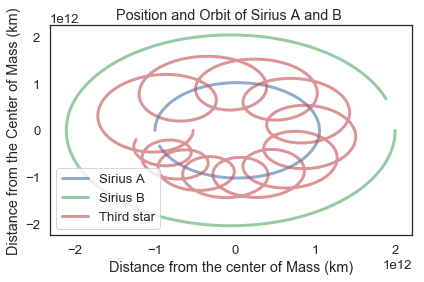

In [59]:
plot(xa, ya, 'b', label = 'Sirius A')
plot(xb,yb, 'g', label = 'Sirius B')
plot(xc,yc,'r' , label = 'Third star')

decorate(title = "Position and Orbit of Sirius A and B ",
        xlabel = 'Distance from the center of Mass (km)',
        ylabel = 'Distance from the Center of Mass (km)')

We can see that even though the third star is mostly orbiting around Sirius A, it is stil affected by the gravitational force from B, and the velocity is not enough to contradict the force from Sirius A. Therefore the orbit of the third star radius is getting smaller and smaller. We can even predict that it will eventually run into A and become a part of SiriusA. 

## If the third star is far away from the Sirius A and B system:

It is actually theoretically the most stable trinary star system. Because the third star is so far away from the original binary system that we can actually view them as a planet orbiting a SINGLE star.

In [60]:

init = State (   xA = -r_0 *1/3,
                 yA = 0 *m,
                 vxA = 0 *m/s,
                 vyA = 2*pi*r_0/(3*T),
                 xB = r_0*2/3,
                 yB = 0 * m,
                 vxB = 0 *m/s,
                 vyB = -4*pi*r_0 /(3*T),
                 xC = 0 * m,
                 yC =  10 * r_0,
                 vxC = 0.63 * pi *r_0/T,
                 vyC = 0 *m/s
    )

,values
xA,-997333333333.3334 meter
yA,0 meter
vxA,0.0 meter / second
vyA,3896.219537683942 meter / second
xB,1994666666666.6667 meter
yB,0 meter
vxB,0.0 meter / second
vyB,-7792.439075367884 meter / second
xC,0 meter
yC,29920000000000.0 meter


In [61]:
TC = 5 * 365 * 24 * 60 *60 *s
system = System(mC = 0.024*m_sun,
                 init = init,
                 G = 6.674e-11 * N / kg**2 * m**2,
                 mA = 2*m_sun, 
                 mB = m_sun,
                 rA = 1.71 * r_sun,
                 rB= 0.008*r_sun,
                 t_0 = 0 *s,
                 t_end = T *7
                 
                )

,values
mC,4.7736e+28 kilogram
init,xA -997333333333.3334 meter yA ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
mA,3.978e+30 kilogram
mB,1.989e+30 kilogram
rA,11893050000.0 meter
rB,55640000.0 meter
t_0,0 second
t_end,11258352000 second


In [62]:
def universal_gravity(state, system):    
    """"
    Calculating gravitational force between Sirius A and Sirius B
    Taking the center of mass as origin
    xA, yA: posistion of Sirius A 
    xB, yB: position of Sirius B
    vxA, vyA: velocity of Sirius A
    vxB, vyB: velocity of Sirius B
    xC, yC: position of the third star
    vxC, vyC: velocity of the third star
    """
    xA, yA, vxA, vyA, xB, yB, vxB, vyB, xC, yC, vxC, vyC= state
    unpack(system)
    posA = Vector (xA, yA)
    posB = Vector (xB, yB)
    posC = Vector (xC, yC)
    AB = posB-posA
    BA = posA-posB
    AC = posA - posC
    BC = posB - posC
    
    forceA =AB.hat() * G * mA *mB/ AB.mag**2
    forceB = BA.hat() * G *mA*mB / BA.mag **2
    forceAC = AC.hat() * G * mA * mC / AC.mag **2
    forceBC = BC.hat() * G * mB * mC / BC.mag **2
    forceC = forceAC + forceBC
    
    return forceA, forceB, forceC
    

In [63]:
def slope_func(state, t, system):
    xA, yA, vxA, vyA, xB, yB, vxB, vyB, xC, yC, vxC, vyC= state
    unpack(system)
    
    forceA,forceB, forceC = universal_gravity(state, system)
    accA = forceA / mA
    accB = forceB / mB
    accC = forceC/ mC
    accAx = accA[0]
    accAy = accA[1]
    accBx = accB[0]
    accBy = accB[1]
    accCx = accC[0]
    accCy = accC[1]    

    
    return vxA, vyA, accAx ,accAy, vxB, vyB, accBx, accBy, vxC, vyC, accCx, accCy
    

In [64]:
results, details = run_ode_solver(system, slope_func)
details

,values
sol,None
t_events,[]
nfev,608
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


In [65]:
t_final = get_last_label(results) * s

<Quantity(11258352000.0, 'second')>

In [66]:
t_final.to(UNITS.years)

<Quantity(356.76326677148813, 'year')>

In [67]:
ts = linspace(t_0, t_final, 500)
results, details = run_ode_solver(system, slope_func, t_eval=ts)
results;

In [68]:
xa = results.xA;
ya = results.yA;
xb = results.xB;
yb = results.yB;
xc = results.xC;
yc = results.yC;

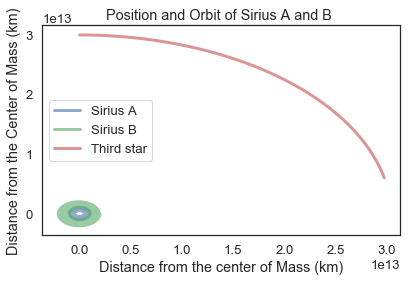

In [69]:
plot(xa, ya, 'b', label = 'Sirius A')
plot(xb,yb, 'g', label = 'Sirius B')
plot(xc,yc,'r' , label = 'Third star')

decorate(title = "Position and Orbit of Sirius A and B ",
        xlabel = 'Distance from the center of Mass (km)',
        ylabel = 'Distance from the Center of Mass (km)')

Only about 1/4 of the orbit of the third star is drawn, which is due to the step size limit of ode solver. We can see that the original 2 stars are almost at the original point which verifies the idea of this trinary system is like star-planet. Also, different initial velocities can significantly affect the trace: the star can either be drawn closer to the binary system or ejected away.

## Moving Around the 2 stars:

If we put the three of them near and the third star has a relatively high velocity so it will not move in a circular orbit at first. The three stars will mess around until the third and lightest one in the system. To clearer illustrate the outcomes, we will draw different traces from different velocities.

## With a pretty ideal intial speed (system generally stable):

In [248]:
init = State (  xA = -r_0 *1/3,
                 yA = 0 *m,
                 vxA = 0 *m/s,
                 vyA = 2*pi*r_0/(3*T),
                 xB = r_0*2/3,
                 yB = 0 * m,
                 vxB = 0 *m/s,
                 vyB = -4*pi*r_0 /(3*T),
                 xC = 0 * m ,
                 yC = 0*m,
                 vxC = 0 *m / s,
                 vyC = -15000 * m/s
    )

,values
xA,-997333333333.3334 meter
yA,0 meter
vxA,0.0 meter / second
vyA,3896.219537683942 meter / second
xB,1994666666666.6667 meter
yB,0 meter
vxB,0.0 meter / second
vyB,-7792.439075367884 meter / second
xC,0 meter
yC,0 meter


In [249]:
TC = 5 * 365 * 24 * 60 *60 *s

system = System(mC = 0.024*m_sun,
                 init = init,
                 G = 6.674e-11 * N / kg**2 * m**2,
                 mA = 2*m_sun, 
                 mB = m_sun,
                 rA = 1.71 * r_sun,
                 rB= 0.008*r_sun,
                 t_0 = 0 *s,
                 t_end = T *2
                 
                )

,values
mC,4.7736e+28 kilogram
init,xA -997333333333.3334 meter yA ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
mA,3.978e+30 kilogram
mB,1.989e+30 kilogram
rA,11893050000.0 meter
rB,55640000.0 meter
t_0,0 second
t_end,3216672000 second


In [250]:
def universal_gravity(state, system):    
    """"
    Calculating gravitational force between Sirius A and Sirius B
    Taking the center of mass as origin
    xA, yA: posistion of Sirius A 
    xB, yB: position of Sirius B
    vxA, vyA: velocity of Sirius A
    vxB, vyB: velocity of Sirius B
    """
    xA, yA, vxA, vyA, xB, yB, vxB, vyB, xC, yC, vxC, vyC= state
    unpack(system)
    posA = Vector (xA, yA)
    posB = Vector (xB, yB)
    posC = Vector (xC, yC)
    AB = posB-posA
    BA = posA-posB
    AC = posA - posC
    BC = posB - posC
    
    
    forceAC = AC.hat() * G * mA * mC / AC.mag **2
    forceBC = BC.hat() * G * mB * mC / BC.mag **2
    forceA =AB.hat() * G * mA *mB/ AB.mag**2 - forceAC
    forceB = BA.hat() * G *mA*mB / BA.mag **2 - forceBC
    
    forceC = forceAC + forceBC
    
    return forceA, forceB, forceC
    

In [251]:
def slope_func(state, t, system):
    xA, yA, vxA, vyA, xB, yB, vxB, vyB, xC, yC, vxC, vyC= state
    unpack(system)
    
    forceA,forceB, forceC = universal_gravity(state, system)
    accA = forceA / mA
    accB = forceB / mB
    accC = forceC/ mC
    accAx = accA[0]
    accAy = accA[1]
    accBx = accB[0]
    accBy = accB[1]
    accCx = accC[0]
    accCy = accC[1]    

    
    return vxA, vyA, accAx ,accAy, vxB, vyB, accBx, accBy, vxC, vyC, accCx, accCy
    

In [252]:
results, details = run_ode_solver(system, slope_func)
details

,values
sol,None
t_events,[]
nfev,518
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


In [253]:
t_final = get_last_label(results) * s

<Quantity(3216672000.0, 'second')>

In [254]:
t_final.to(UNITS.years)

<Quantity(101.9323619347109, 'year')>

In [255]:
ts = linspace(t_0, t_final, 1000)
results, details = run_ode_solver(system, slope_func, t_eval=ts)


In [256]:
xa = results.xA;
ya = results.yA;
xb = results.xB;
yb = results.yB;
xc = results.xC;
yc = results.yC;

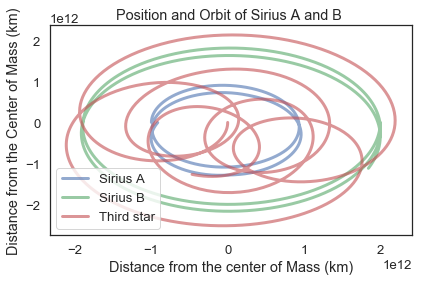

In [257]:
plot(xa, ya, 'b', label = 'Sirius A')
plot(xb,yb, 'g', label = 'Sirius B')
plot(xc,yc,'r' , label = 'Third star')

decorate(title = "Position and Orbit of Sirius A and B ",
        xlabel = 'Distance from the center of Mass (km)',
        ylabel = 'Distance from the Center of Mass (km)')

#### We can see that the orbits of Sirius A and B are slightly affected and the third is switching the center and moving around them.

## With a small initial speed:

In [258]:
init = State (  xA = -r_0 *1/3,
                 yA = 0 *m,
                 vxA = 0 *m/s,
                 vyA = 2*pi*r_0/(3*T),
                 xB = r_0*2/3,
                 yB = 0 * m,
                 vxB = 0 *m/s,
                 vyB = -4*pi*r_0 /(3*T),
                 xC = 0 * m ,
                 yC = 0*m,
                 vxC = 0 *m / s,
                 vyC = -20000* m/s
    )

,values
xA,-997333333333.3334 meter
yA,0 meter
vxA,0.0 meter / second
vyA,3896.219537683942 meter / second
xB,1994666666666.6667 meter
yB,0 meter
vxB,0.0 meter / second
vyB,-7792.439075367884 meter / second
xC,0 meter
yC,0 meter


In [204]:
TC = 5 * 365 * 24 * 60 *60 *s

system = System(mC = 0.024*m_sun,
                 init = init,
                 G = 6.674e-11 * N / kg**2 * m**2,
                 mA = 2*m_sun, 
                 mB = m_sun,
                 rA = 1.71 * r_sun,
                 rB= 0.008*r_sun,
                 t_0 = 0 *s,
                 t_end = T * 4
                 
                )

,values
mC,4.7736e+28 kilogram
init,xA -997333333333.3334 meter yA ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
mA,3.978e+30 kilogram
mB,1.989e+30 kilogram
rA,11893050000.0 meter
rB,55640000.0 meter
t_0,0 second
t_end,6433344000 second


In [205]:
def universal_gravity(state, system):    
    """"
    Calculating gravitational force between Sirius A and Sirius B
    Taking the center of mass as origin
    xA, yA: posistion of Sirius A 
    xB, yB: position of Sirius B
    vxA, vyA: velocity of Sirius A
    vxB, vyB: velocity of Sirius B
    """
    xA, yA, vxA, vyA, xB, yB, vxB, vyB, xC, yC, vxC, vyC= state
    unpack(system)
    posA = Vector (xA, yA)
    posB = Vector (xB, yB)
    posC = Vector (xC, yC)
    AB = posB-posA
    BA = posA-posB
    AC = posA - posC
    BC = posB - posC
    
    
    forceAC = AC.hat() * G * mA * mC / AC.mag **2
    forceBC = BC.hat() * G * mB * mC / BC.mag **2
    forceA =AB.hat() * G * mA *mB/ AB.mag**2 - forceAC
    forceB = BA.hat() * G *mA*mB / BA.mag **2 - forceBC
    
    forceC = forceAC + forceBC
    
    return forceA, forceB, forceC
    

In [206]:
def slope_func(state, t, system):
    xA, yA, vxA, vyA, xB, yB, vxB, vyB, xC, yC, vxC, vyC= state
    unpack(system)
    
    forceA,forceB, forceC = universal_gravity(state, system)
    accA = forceA / mA
    accB = forceB / mB
    accC = forceC/ mC
    accAx = accA[0]
    accAy = accA[1]
    accBx = accB[0]
    accBy = accB[1]
    accCx = accC[0]
    accCy = accC[1]    

    
    return vxA, vyA, accAx ,accAy, vxB, vyB, accBx, accBy, vxC, vyC, accCx, accCy
    

In [207]:
results, details = run_ode_solver(system, slope_func)
details

,values
sol,None
t_events,[]
nfev,884
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


In [208]:
t_final = get_last_label(results) * s
t_final.to(UNITS.years)

<Quantity(203.8647238694218, 'year')>

In [209]:
ts = linspace(t_0, t_final, 1000)
results, details = run_ode_solver(system, slope_func, t_eval=ts)


In [210]:
xa = results.xA;
ya = results.yA;
xb = results.xB;
yb = results.yB;
xc = results.xC;
yc = results.yC;

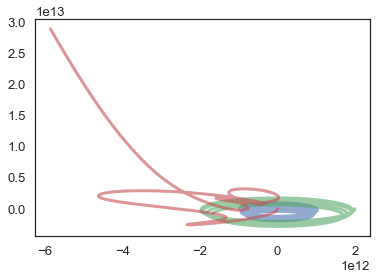

In [211]:
plot(xa, ya, 'b', label = 'Sirius A')
plot(xb,yb, 'g', label = 'Sirius B')
plot(xc,yc,'r' , label = 'Third star')

decorate(title = "Position and Orbit of Sirius A and B ",
        xlabel = 'Distance from the center of Mass (km)',
        ylabel = 'Distance from the Center of Mass (km)')

#### The third star is ejected pretty quickly and the original system is not affected. This is because if the initial velocity is too high and the gravitational force is not enough to serve as the centripetal force it needed to keep the circular motion, the star would escape, and because the kinetic energy is too high and when it reaches the orbit with fit radius and velocity, the gravitational force is already too small to keep it in an orbit and therefore the third will be in a constant speed until it is captured by another star that has a strong enough gravitational force to hold it in the orbit.

## With a relatively low speed:

In [259]:
init = State (  xA = -r_0 *1/3,
                 yA = 0 *m,
                 vxA = 0 *m/s,
                 vyA = 2*pi*r_0/(3*T),
                 xB = r_0*2/3,
                 yB = 0 * m,
                 vxB = 0 *m/s,
                 vyB = -4*pi*r_0 /(3*T),
                 xC = 0 * m ,
                 yC = 0*m,
                 vxC = 0 *m / s,
                 vyC = -1000* m/s
    )

,values
xA,-997333333333.3334 meter
yA,0 meter
vxA,0.0 meter / second
vyA,3896.219537683942 meter / second
xB,1994666666666.6667 meter
yB,0 meter
vxB,0.0 meter / second
vyB,-7792.439075367884 meter / second
xC,0 meter
yC,0 meter


In [260]:
TC = 5 * 365 * 24 * 60 *60 *s

system = System(mC = 0.024*m_sun,
                 init = init,
                 G = 6.674e-11 * N / kg**2 * m**2,
                 mA = 2*m_sun, 
                 mB = m_sun,
                 rA = 1.71 * r_sun,
                 rB= 0.008*r_sun,
                 t_0 = 0 *s,
                 t_end = T * 2
                 
                )

,values
mC,4.7736e+28 kilogram
init,xA -997333333333.3334 meter yA ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
mA,3.978e+30 kilogram
mB,1.989e+30 kilogram
rA,11893050000.0 meter
rB,55640000.0 meter
t_0,0 second
t_end,3216672000 second


In [261]:
def universal_gravity(state, system):    
    """"
    Calculating gravitational force between Sirius A and Sirius B
    Taking the center of mass as origin
    xA, yA: posistion of Sirius A 
    xB, yB: position of Sirius B
    vxA, vyA: velocity of Sirius A
    vxB, vyB: velocity of Sirius B
    """
    xA, yA, vxA, vyA, xB, yB, vxB, vyB, xC, yC, vxC, vyC= state
    unpack(system)
    posA = Vector (xA, yA)
    posB = Vector (xB, yB)
    posC = Vector (xC, yC)
    AB = posB-posA
    BA = posA-posB
    AC = posA - posC
    BC = posB - posC
    
    
    forceAC = AC.hat() * G * mA * mC / AC.mag **2
    forceBC = BC.hat() * G * mB * mC / BC.mag **2
    forceA =AB.hat() * G * mA *mB/ AB.mag**2 - forceAC
    forceB = BA.hat() * G *mA*mB / BA.mag **2 - forceBC
    
    forceC = forceAC + forceBC
    
    return forceA, forceB, forceC
    

In [262]:
def slope_func(state, t, system):
    xA, yA, vxA, vyA, xB, yB, vxB, vyB, xC, yC, vxC, vyC= state
    unpack(system)
    
    forceA,forceB, forceC = universal_gravity(state, system)
    accA = forceA / mA
    accB = forceB / mB
    accC = forceC/ mC
    accAx = accA[0]
    accAy = accA[1]
    accBx = accB[0]
    accBy = accB[1]
    accCx = accC[0]
    accCy = accC[1]    

    
    return vxA, vyA, accAx ,accAy, vxB, vyB, accBx, accBy, vxC, vyC, accCx, accCy
    

In [263]:
results, details = run_ode_solver(system, slope_func)
details

,values
sol,None
t_events,[]
nfev,3164
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


In [264]:
t_final = get_last_label(results) * s
t_final.to(UNITS.years)

<Quantity(101.9323619347109, 'year')>

In [265]:
ts = linspace(t_0, t_final, 1000)
results, details = run_ode_solver(system, slope_func, t_eval=ts)


In [266]:
xa = results.xA;
ya = results.yA;
xb = results.xB;
yb = results.yB;
xc = results.xC;
yc = results.yC;

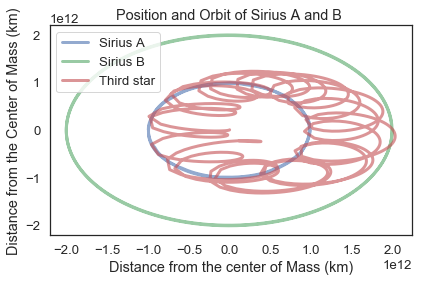

In [267]:
plot(xa, ya, 'b', label = 'Sirius A')
plot(xb,yb, 'g', label = 'Sirius B')
plot(xc,yc,'r' , label = 'Third star')

decorate(title = "Position and Orbit of Sirius A and B ",
        xlabel = 'Distance from the center of Mass (km)',
        ylabel = 'Distance from the Center of Mass (km)')

#### This trace is quite similar to the first one in which the third star is considered a companion of Sirius A. Because the velocity it has is smaller than the gravitational force from Sirius A, so it is captured and orbits around Sirius A. However, we can still see the trand of collapsing.

# Abstract: 

This trinary star model is based on the binary system of Sirius. Most situiation are covered. The model effectively illustrated the different moving patterns of trinary stars which are harder to imagine. Also we used model to verify the statement that trinary star systems, especially when one is considerably light (to be considered a planet), are unstable and most of them will evolve into binary systems.